# 🎯 Credit Score Classification - Advanced Multi-Model Pipeline

**Author:** Mayank Singh  
**Project:** Multi-model machine learning pipeline for credit score prediction

---

## 📋 Project Overview

This comprehensive machine learning project delivers a robust classification system for predicting credit scores using authentic financial data sourced through Kaggle's API. The system intelligently categorizes customers into three distinct credit risk levels:

- **🔴 Poor (0)**: High risk, low creditworthiness
- **🟡 Standard (1)**: Medium risk, average creditworthiness  
- **🟢 Good (2)**: Low risk, high creditworthiness

### 🚀 Key Features
- **Multi-Model Comparison**: Random Forest, XGBoost, and LightGBM
- **Automated Data Download**: Direct integration with Kaggle API
- **Hyperparameter Optimization**: GridSearchCV for optimal performance
- **Self-Evaluation Framework**: Rigorous validation methodology
- **Production-Ready Code**: Clean, modular, and well-documented

---

## 📦 Installation & Setup

Before running this notebook, ensure you have the required packages installed:

```bash
pip install pandas numpy scikit-learn xgboost lightgbm kaggle matplotlib seaborn
```

### 🔑 Kaggle API Setup
1. Create a Kaggle account and go to your account settings
2. Click "Create New API Token" to download `kaggle.json`
3. Place the file in your home directory: `~/.kaggle/kaggle.json` (Linux/Mac) or `C:\Users\{username}\.kaggle\kaggle.json` (Windows)
4. Ensure the file permissions are set correctly

---

In [1]:
# 📚 Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import os
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display options
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 📥 Data Download & Loading

We'll download the credit score dataset directly from Kaggle using their API.

In [2]:
def download_kaggle_data():
    """
    Download the credit score dataset from Kaggle using the API
    """
    print("🔄 Downloading data from Kaggle...")
    
    try:
        # Download the dataset
        kaggle.api.dataset_download_files('mavimayank/train-and-test-creditscore', 
                                         path='.', 
                                         unzip=True)
        
        print("✅ Data downloaded successfully!")
        
        # Verify files exist
        if os.path.exists('train.csv') and os.path.exists('test.csv'):
            print("✅ train.csv and test.csv found")
            return True
        else:
            print("❌ Error: Data files not found after download")
            return False
    except Exception as e:
        print(f"❌ Error downloading data: {e}")
        return False

def load_data():
    """
    Load training and test data with smart environment detection
    """
    # Check if running in Kaggle environment
    kaggle_paths = [
        '/kaggle/input/credit-score-classification/train.csv',
        '/kaggle/input/train-and-test-creditscore/train.csv'
    ]
    
    # Try Kaggle environment first
    for kaggle_path in kaggle_paths:
        if os.path.exists(kaggle_path):
            print("🏠 Detected Kaggle environment - using direct paths")
            train_path = kaggle_path
            test_path = kaggle_path.replace('train.csv', 'test.csv')
            
            if os.path.exists(test_path):
                train = pd.read_csv(train_path)
                test = pd.read_csv(test_path)
                print(f"✅ Loaded from Kaggle environment")
                print(f"📊 Training data shape: {train.shape}")
                print(f"📊 Test data shape: {test.shape}")
                return train, test
    
    # Check if data files exist locally
    if os.path.exists('train.csv') and os.path.exists('test.csv'):
        print("📁 Using existing local data files...")
        train = pd.read_csv('train.csv')
        test = pd.read_csv('test.csv')
    else:
        print("📁 Data files not found locally. Downloading from Kaggle...")
        if not download_kaggle_data():
            raise FileNotFoundError("Failed to download data from Kaggle")
        train = pd.read_csv('train.csv')
        test = pd.read_csv('test.csv')
    
    print(f"📊 Training data shape: {train.shape}")
    print(f"📊 Test data shape: {test.shape}")
    
    return train, test

# Load the data with smart environment detection
try:
    train_df, test_df = load_data()
    print("🎉 Data loading successful!")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("💡 Tip: Make sure you have Kaggle API credentials set up or are running in Kaggle environment")

📁 Data files not found locally. Downloading from Kaggle...
🔄 Downloading data from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/mavimayank/train-and-test-creditscore
✅ Data downloaded successfully!
✅ train.csv and test.csv found
📊 Training data shape: (100000, 28)
📊 Test data shape: (50000, 27)
🎉 Data loading successful!


## 🔍 Data Exploration

Let's explore our dataset to understand its structure and characteristics.

🔍 DATASET OVERVIEW
Training samples: 100,000
Features: 28
Test samples: 50,000

📋 FIRST FEW ROWS:


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good



📊 DATA TYPES:
object     20
float64     4
int64       4
Name: count, dtype: int64

🎯 TARGET VARIABLE DISTRIBUTION:
Credit_Score
Good        17828
Poor        28998
Standard    53174
Name: count, dtype: int64


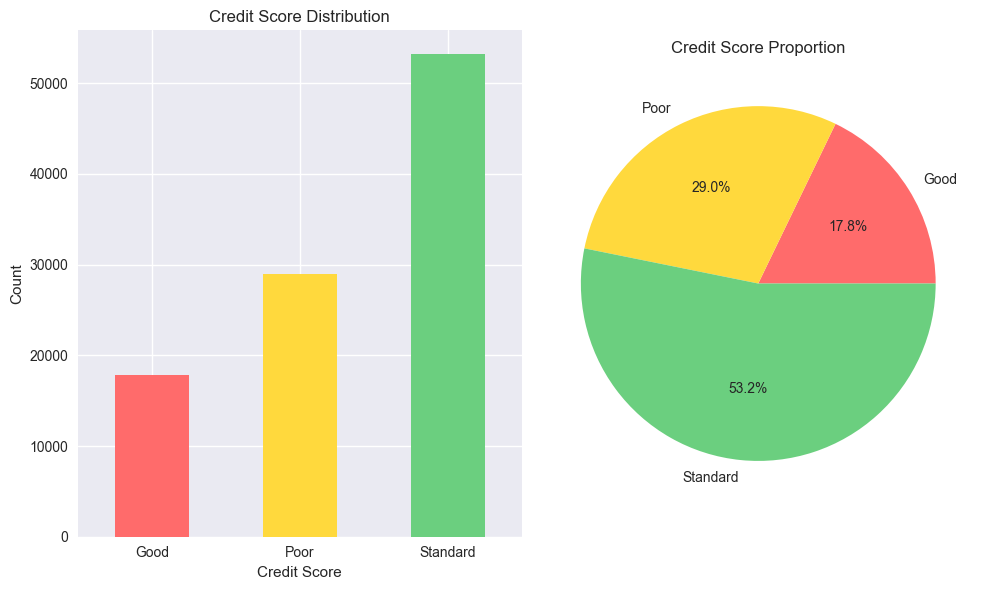

In [3]:
# Display basic information about the dataset
print("🔍 DATASET OVERVIEW")
print("=" * 50)
print(f"Training samples: {train_df.shape[0]:,}")
print(f"Features: {train_df.shape[1]}")
print(f"Test samples: {test_df.shape[0]:,}")

print("\n📋 FIRST FEW ROWS:")
display(train_df.head())

print("\n📊 DATA TYPES:")
print(train_df.dtypes.value_counts())

print("\n🎯 TARGET VARIABLE DISTRIBUTION:")
target_dist = train_df['Credit_Score'].value_counts().sort_index()
print(target_dist)

# Visualize target distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
target_dist.plot(kind='bar', color=['#ff6b6b', '#ffd93d', '#6bcf7f'])
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(target_dist.values, labels=target_dist.index, autopct='%1.1f%%', 
        colors=['#ff6b6b', '#ffd93d', '#6bcf7f'])
plt.title('Credit Score Proportion')

plt.tight_layout()
plt.show()

## 🛠️ Data Preprocessing Functions

We'll define comprehensive preprocessing functions to clean and prepare our data.

In [4]:
def drop_identifiers(df):
    """Remove identifier columns that don't contribute to prediction"""
    columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN']
    columns_found = [col for col in columns_to_drop if col in df.columns]
    if columns_found:
        print(f"🗑️ Dropping identifier columns: {columns_found}")
    return df.drop(columns=columns_found, errors='ignore')

def clean_numerics(df, cols):
    """Convert text-based numbers to proper numeric format"""
    print(f"🔢 Cleaning {len(cols)} numeric columns...")
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def correct_and_impute(df, impute_cols):
    """Correct invalid values and impute missing data"""
    print("🩹 Correcting invalid values and imputing missing data...")
    
    # Age correction
    if 'Age' in df.columns:
        invalid_ages = ((df['Age'] < 18) | (df['Age'] > 100)).sum()
        if invalid_ages > 0:
            print(f"   ⚠️ Found {invalid_ages} invalid age values, replacing with NaN")
            df.loc[(df['Age'] < 18) | (df['Age'] > 100), 'Age'] = np.nan
    
    # Create imputation dictionary with median values
    imputation_dict = {}
    for col in impute_cols:
        if col in df.columns:
            median_val = df[col].median()
            imputation_dict[col] = median_val
    
    print(f"   📊 Imputing {len(imputation_dict)} columns with median values")
    df.fillna(value=imputation_dict, inplace=True)
    
    return df, imputation_dict

def convert_credit_history_age(df):
    """Convert credit history text to numerical months"""
    if 'Credit_History_Age' in df.columns:
        print("📅 Converting credit history age to numerical format...")
        
        df['Credit_History_Age'].fillna('0 Years and 0 Months', inplace=True)
        
        # Extract years and months using regex
        years = df['Credit_History_Age'].str.extract(r'(\d+)').astype(int)
        months = df['Credit_History_Age'].str.extract(r'(\d+)\s*Months').astype(int)
        
        # Convert to total months
        df['Credit_History_Age_Months'] = (years * 12) + months
        df.drop(columns=['Credit_History_Age'], inplace=True)
        
        print("   ✅ Credit history converted to months")
    
    return df

def handle_type_of_loan(df, vectorizer=None, fit=True):
    """Handle multiple loan types using multi-hot encoding"""
    if 'Type_of_Loan' not in df.columns:
        return df, vectorizer
    
    print("💳 Processing loan types with multi-hot encoding...")
    
    df['Type_of_Loan'].fillna('No_Loan', inplace=True)
    
    def smart_tokenizer(s):
        """Custom tokenizer to handle loan type combinations"""
        s_cleaned = s.replace(', and ', ',')
        tokens = [token.strip() for token in s_cleaned.split(',')]
        return tokens
    
    if fit:
        vectorizer = CountVectorizer(tokenizer=smart_tokenizer)
        loan_features = vectorizer.fit_transform(df['Type_of_Loan'])
        print(f"   📊 Created {len(vectorizer.get_feature_names_out())} loan type features")
    else:
        loan_features = vectorizer.transform(df['Type_of_Loan'])
    
    # Create loan features DataFrame
    loan_df = pd.DataFrame(loan_features.toarray(), 
                          columns=vectorizer.get_feature_names_out())
    loan_df = loan_df.add_prefix('loan_')
    
    # Combine with original DataFrame
    df = df.reset_index(drop=True)
    loan_df = loan_df.reset_index(drop=True)
    df = pd.concat([df, loan_df], axis=1)
    df.drop(columns=['Type_of_Loan'], inplace=True)
    
    return df, vectorizer

def encode_features(df, target=False):
    """Encode categorical features and target variable"""
    if target and 'Credit_Score' in df.columns:
        print("🎯 Encoding target variable...")
        score_mapping = {'Poor': 0, 'Standard': 1, 'Good': 2}
        df['Credit_Score'] = df['Credit_Score'].map(score_mapping)
    
    # One-hot encode categorical features
    cols_to_encode = ['Month', 'Occupation', 'Credit_Mix', 
                     'Payment_of_Min_Amount', 'Payment_Behaviour']
    cols_found = [col for col in cols_to_encode if col in df.columns]
    
    if cols_found:
        print(f"🏷️ One-hot encoding {len(cols_found)} categorical features...")
        df = pd.get_dummies(df, columns=cols_found, drop_first=True)
    
    return df

print("✅ All preprocessing functions defined!")

✅ All preprocessing functions defined!


## 🔄 Data Preprocessing Pipeline

Now let's apply our preprocessing pipeline to clean and prepare the data.

In [5]:
def preprocess_data(df, impute_cols, vectorizer=None, fit_vectorizer=True, imputation_dict=None):
    """Complete preprocessing pipeline"""
    print(f"\n🔄 PREPROCESSING PIPELINE")
    print("=" * 40)
    
    # Make a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Step 1: Drop identifiers
    df_processed = drop_identifiers(df_processed)
    
    # Step 2: Clean numeric columns
    df_processed = clean_numerics(df_processed, impute_cols)
    
    # Step 3: Correct and impute
    if imputation_dict is None:
        df_processed, imputation_dict = correct_and_impute(df_processed, impute_cols)
    else:
        df_processed.fillna(value=imputation_dict, inplace=True)
        print("🩹 Applied existing imputation values")
    
    # Step 4: Convert credit history
    df_processed = convert_credit_history_age(df_processed)
    
    # Step 5: Handle loan types
    df_processed, vectorizer = handle_type_of_loan(df_processed, vectorizer, fit=fit_vectorizer)
    
    # Step 6: Encode features
    df_processed = encode_features(df_processed)
    
    print(f"✅ Preprocessing complete! Shape: {df_processed.shape}")
    return df_processed, vectorizer, imputation_dict

# Define columns to clean and impute
impute_cols = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_of_Loan',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance'
]

# Process training data
train_processed, loan_vectorizer, imputation_values = preprocess_data(
    train_df, impute_cols, fit_vectorizer=True
)

# Encode target variable for training data
train_processed = encode_features(train_processed, target=True)

# Separate features and target
X_train_full = train_processed.drop(columns=['Credit_Score'])
y_train_full = train_processed['Credit_Score']

print(f"\n📊 Final training data shape: {X_train_full.shape}")
print(f"📊 Target variable shape: {y_train_full.shape}")
print(f"📊 Target distribution: {y_train_full.value_counts().to_dict()}")


🔄 PREPROCESSING PIPELINE
🗑️ Dropping identifier columns: ['ID', 'Customer_ID', 'Name', 'SSN']
🔢 Cleaning 10 numeric columns...
🩹 Correcting invalid values and imputing missing data...
   ⚠️ Found 8124 invalid age values, replacing with NaN
   📊 Imputing 10 columns with median values
📅 Converting credit history age to numerical format...
   ✅ Credit history converted to months
💳 Processing loan types with multi-hot encoding...
   📊 Created 10 loan type features
🏷️ One-hot encoding 5 categorical features...
✅ Preprocessing complete! Shape: (100000, 61)
🎯 Encoding target variable...

📊 Final training data shape: (100000, 60)
📊 Target variable shape: (100000,)
📊 Target distribution: {1: 53174, 0: 28998, 2: 17828}


## 🧪 Self-Evaluation Setup

We'll create a validation split to evaluate our models objectively.

In [6]:
# Create validation split for self-evaluation
print("🧪 CREATING VALIDATION SPLIT")
print("=" * 40)

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_full
)

print(f"✅ Training split shape: {X_train_split.shape}")
print(f"✅ Validation split shape: {X_val.shape}")
print(f"✅ Class distribution maintained in both splits")

# Feature scaling
print("\n⚖️ APPLYING FEATURE SCALING")
print("=" * 40)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)

print("✅ Feature scaling complete!")
print(f"   📊 Scaled training features shape: {X_train_scaled.shape}")
print(f"   📊 Scaled validation features shape: {X_val_scaled.shape}")

🧪 CREATING VALIDATION SPLIT
✅ Training split shape: (80000, 60)
✅ Validation split shape: (20000, 60)
✅ Class distribution maintained in both splits

⚖️ APPLYING FEATURE SCALING
✅ Feature scaling complete!
   📊 Scaled training features shape: (80000, 60)
   📊 Scaled validation features shape: (20000, 60)


## 🤖 Multi-Model Training & Evaluation

We'll train and compare three powerful machine learning models.

In [7]:
def train_and_evaluate_models(X_train, X_val, y_train, y_val):
    """
    Train multiple models and return their performance metrics
    """
    results = {}
    
    print("\n🤖 MULTI-MODEL TRAINING & EVALUATION")
    print("=" * 60)
    
    # 1. Random Forest
    print("\n🌲 1. Training Random Forest...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_val)
    rf_accuracy = accuracy_score(y_val, rf_pred)
    
    results['Random Forest'] = {
        'model': rf_model,
        'predictions': rf_pred,
        'accuracy': rf_accuracy,
        'report': classification_report(y_val, rf_pred, target_names=['Poor', 'Standard', 'Good'])
    }
    print(f"   ✅ Random Forest Accuracy: {rf_accuracy:.4f}")
    
    # 2. XGBoost with Grid Search
    print("\n🚀 2. Training XGBoost with hyperparameter tuning...")
    
    param_grid_xgb = {
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05]
    }
    
    xgb_base = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=-1
    )
    
    grid_search_xgb = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid_xgb,
        cv=3,
        verbose=0,
        n_jobs=-1
    )
    
    grid_search_xgb.fit(X_train, y_train)
    best_xgb = grid_search_xgb.best_estimator_
    xgb_pred = best_xgb.predict(X_val)
    xgb_accuracy = accuracy_score(y_val, xgb_pred)
    
    results['XGBoost'] = {
        'model': best_xgb,
        'predictions': xgb_pred,
        'accuracy': xgb_accuracy,
        'best_params': grid_search_xgb.best_params_,
        'report': classification_report(y_val, xgb_pred, target_names=['Poor', 'Standard', 'Good'])
    }
    print(f"   ✅ XGBoost Accuracy: {xgb_accuracy:.4f}")
    print(f"   🔧 Best Parameters: {grid_search_xgb.best_params_}")
    
    # 3. LightGBM with Grid Search
    print("\n💡 3. Training LightGBM with hyperparameter tuning...")
    
    param_grid_lgb = {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.1, 0.05],
        'num_leaves': [20, 31, 40],
    }
    
    lgb_base = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=3,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    grid_search_lgb = GridSearchCV(
        estimator=lgb_base,
        param_grid=param_grid_lgb,
        cv=3,
        verbose=0,
        n_jobs=-1
    )
    
    grid_search_lgb.fit(X_train, y_train)
    best_lgb = grid_search_lgb.best_estimator_
    lgb_pred = best_lgb.predict(X_val)
    lgb_accuracy = accuracy_score(y_val, lgb_pred)
    
    results['LightGBM'] = {
        'model': best_lgb,
        'predictions': lgb_pred,
        'accuracy': lgb_accuracy,
        'best_params': grid_search_lgb.best_params_,
        'report': classification_report(y_val, lgb_pred, target_names=['Poor', 'Standard', 'Good'])
    }
    print(f"   ✅ LightGBM Accuracy: {lgb_accuracy:.4f}")
    print(f"   🔧 Best Parameters: {grid_search_lgb.best_params_}")
    
    return results

# Train all models
model_results = train_and_evaluate_models(X_train_scaled, X_val_scaled, y_train_split, y_val)


🤖 MULTI-MODEL TRAINING & EVALUATION

🌲 1. Training Random Forest...
   ✅ Random Forest Accuracy: 0.7883

🚀 2. Training XGBoost with hyperparameter tuning...
   ✅ XGBoost Accuracy: 0.7588
   🔧 Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

💡 3. Training LightGBM with hyperparameter tuning...
   ✅ LightGBM Accuracy: 0.7841
   🔧 Best Parameters: {'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 40}


## 📊 Model Comparison & Results

Let's analyze and compare the performance of all three models.


📊 MODEL PERFORMANCE COMPARISON

🎯 ACCURACY SUMMARY:
----------------------------------------
Random Forest  : 0.7883 ⭐⭐⭐
XGBoost        : 0.7588 ⭐⭐⭐
LightGBM       : 0.7841 ⭐⭐⭐

🏆 BEST MODEL: Random Forest with accuracy: 0.7883


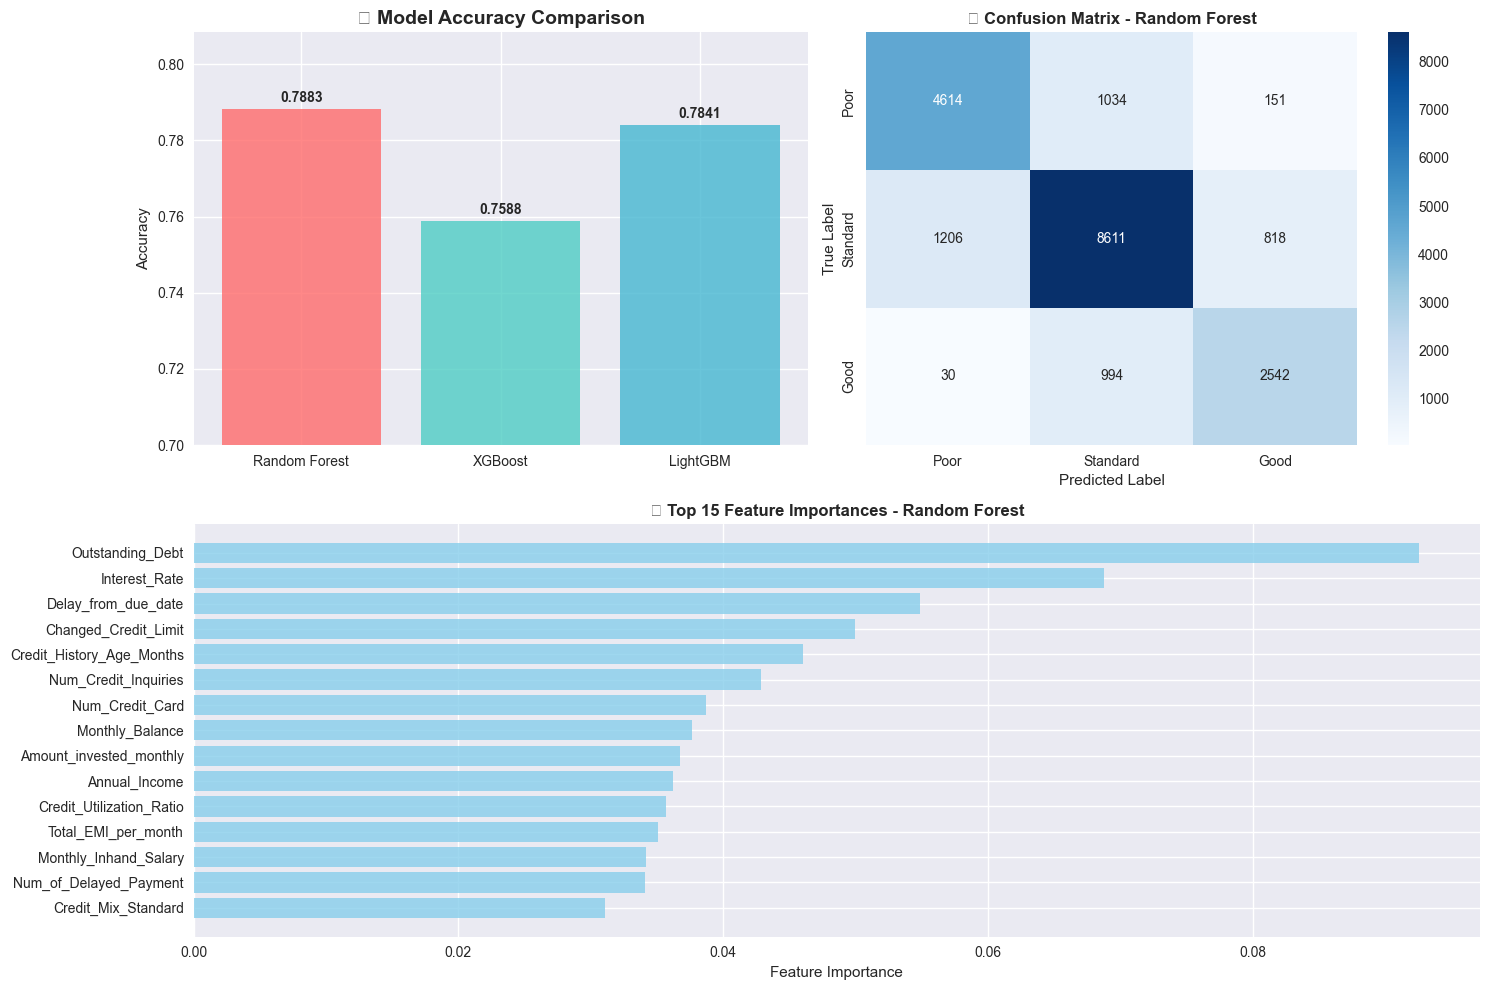


📋 DETAILED CLASSIFICATION REPORTS

🌲 RANDOM FOREST PERFORMANCE:
------------------------------------------------------------
Accuracy: 0.7883

Classification Report:
              precision    recall  f1-score   support

        Poor       0.79      0.80      0.79      5799
    Standard       0.81      0.81      0.81     10635
        Good       0.72      0.71      0.72      3566

    accuracy                           0.79     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.79      0.79      0.79     20000

------------------------------------------------------------

🚀 XGBOOST PERFORMANCE:
------------------------------------------------------------
Accuracy: 0.7588
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

        Poor       0.77      0.74      0.75      5799
    Standard       0.78      0.79      0.79     10635
        Good       0.67  

In [8]:
def print_model_comparison(results):
    """
    Print comprehensive comparison of all models
    """
    print("\n📊 MODEL PERFORMANCE COMPARISON")
    print("=" * 80)
    
    # Create accuracy comparison
    model_names = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in model_names]
    
    # Summary table
    print("\n🎯 ACCURACY SUMMARY:")
    print("-" * 40)
    for model_name, accuracy in zip(model_names, accuracies):
        stars = "⭐" * int(accuracy * 5)  # Visual rating
        print(f"{model_name:<15}: {accuracy:.4f} {stars}")
    
    # Best model
    best_idx = np.argmax(accuracies)
    best_model_name = model_names[best_idx]
    best_accuracy = accuracies[best_idx]
    
    print(f"\n🏆 BEST MODEL: {best_model_name} with accuracy: {best_accuracy:.4f}")
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Accuracy comparison bar plot
    plt.subplot(2, 2, 1)
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    bars = plt.bar(model_names, accuracies, color=colors, alpha=0.8)
    plt.title('🎯 Model Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.ylim(0.7, max(accuracies) + 0.02)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Confusion matrix for best model
    from sklearn.metrics import confusion_matrix
    plt.subplot(2, 2, 2)
    best_model_preds = results[best_model_name]['predictions']
    cm = confusion_matrix(y_val, best_model_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Poor', 'Standard', 'Good'],
                yticklabels=['Poor', 'Standard', 'Good'])
    plt.title(f'🎯 Confusion Matrix - {best_model_name}', fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Feature importance for best model (if available)
    plt.subplot(2, 1, 2)
    best_model = results[best_model_name]['model']
    
    if hasattr(best_model, 'feature_importances_'):
        feature_names = X_train_full.columns
        importances = best_model.feature_importances_
        
        # Get top 15 features
        indices = np.argsort(importances)[::-1][:15]
        top_features = [feature_names[i] for i in indices]
        top_importances = [importances[i] for i in indices]
        
        plt.barh(range(len(top_features)), top_importances, color='skyblue', alpha=0.8)
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Feature Importance')
        plt.title(f'🔝 Top 15 Feature Importances - {best_model_name}', fontweight='bold')
        plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Detailed reports
    print("\n📋 DETAILED CLASSIFICATION REPORTS")
    print("=" * 80)
    
    for model_name, result in results.items():
        print(f"\n{'🌲' if 'Random' in model_name else '🚀' if 'XG' in model_name else '💡'} {model_name.upper()} PERFORMANCE:")
        print("-" * 60)
        print(f"Accuracy: {result['accuracy']:.4f}")
        
        if 'best_params' in result:
            print(f"Best Parameters: {result['best_params']}")
        
        print("\nClassification Report:")
        print(result['report'])
        print("-" * 60)
    
    return best_model_name, results[best_model_name]['model']

# Print comprehensive comparison
best_model_name, best_model = print_model_comparison(model_results)

## 🧪 Test Data Processing & Prediction

Now let's process the test data and create our final predictions.

🧪 PROCESSING TEST DATA

🔄 PREPROCESSING PIPELINE
🗑️ Dropping identifier columns: ['ID', 'Customer_ID', 'Name', 'SSN']
🔢 Cleaning 10 numeric columns...
🩹 Applied existing imputation values
📅 Converting credit history age to numerical format...
   ✅ Credit history converted to months
💳 Processing loan types with multi-hot encoding...
🏷️ One-hot encoding 5 categorical features...
✅ Preprocessing complete! Shape: (50000, 56)
✅ Test data processed! Shape: (50000, 60)

🔮 MAKING PREDICTIONS WITH Random Forest
✅ Predictions saved to: submission_random_forest.csv
📊 Total predictions: 50,000

📈 PREDICTION DISTRIBUTION:
   Standard: 26,569 (53.1%)
   Poor: 14,692 (29.4%)
   Good: 8,739 (17.5%)

👀 SUBMISSION PREVIEW:


,Customer_ID,Credit_Score
0,CUS_0xd40,Good
1,CUS_0xd40,Good
2,CUS_0xd40,Good
3,CUS_0xd40,Good
4,CUS_0x21b1,Good
5,CUS_0x21b1,Good
6,CUS_0x21b1,Standard
7,CUS_0x21b1,Good
8,CUS_0x2dbc,Good
9,CUS_0x2dbc,Good


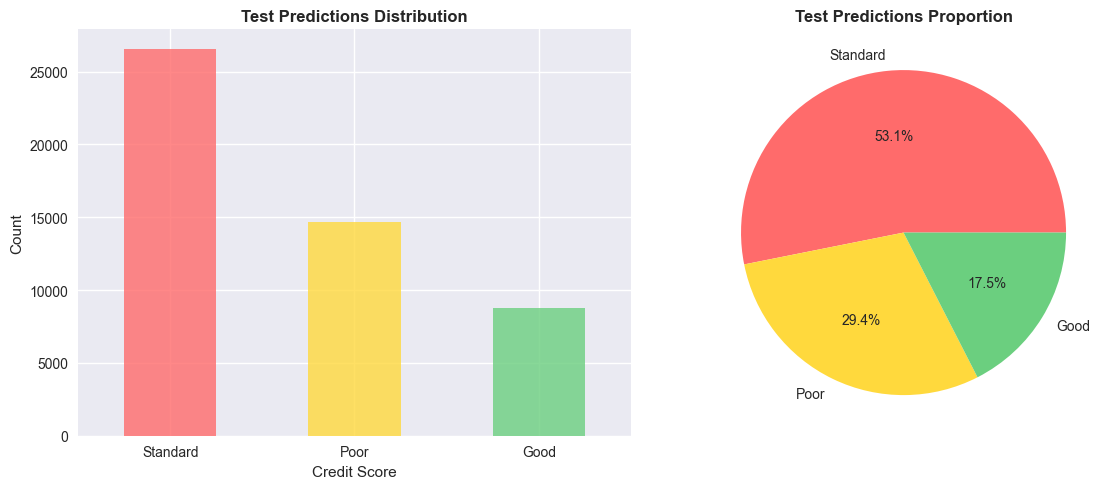

In [9]:
# Process test data
print("🧪 PROCESSING TEST DATA")
print("=" * 40)

# Store customer IDs for submission
test_customer_ids = test_df['Customer_ID'].copy()

# Preprocess test data using same parameters as training
test_processed, _, _ = preprocess_data(
    test_df, 
    impute_cols, 
    vectorizer=loan_vectorizer, 
    fit_vectorizer=False, 
    imputation_dict=imputation_values
)

# Align test data columns with training data
test_processed, X_train_full_aligned = test_processed.align(X_train_full, join='right', axis=1, fill_value=0)

# Scale test data using the same scaler
X_test_scaled = scaler.transform(test_processed)

print(f"✅ Test data processed! Shape: {X_test_scaled.shape}")

# Make predictions using the best model
print(f"\n🔮 MAKING PREDICTIONS WITH {best_model_name}")
print("=" * 50)

test_predictions = best_model.predict(X_test_scaled)

# Map predictions back to text labels
reverse_score_mapping = {0: 'Poor', 1: 'Standard', 2: 'Good'}
mapped_predictions = pd.Series(test_predictions).map(reverse_score_mapping)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'Customer_ID': test_customer_ids,
    'Credit_Score': mapped_predictions
})

# Save submission file
submission_filename = f'submission_{best_model_name.lower().replace(" ", "_")}.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"✅ Predictions saved to: {submission_filename}")
print(f"📊 Total predictions: {len(submission_df):,}")

# Display prediction distribution
pred_dist = submission_df['Credit_Score'].value_counts()
print(f"\n📈 PREDICTION DISTRIBUTION:")
for score, count in pred_dist.items():
    percentage = count / len(submission_df) * 100
    print(f"   {score}: {count:,} ({percentage:.1f}%)")

# Preview submission
print(f"\n👀 SUBMISSION PREVIEW:")
display(submission_df.head(10))

# Visualize prediction distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
pred_dist.plot(kind='bar', color=['#ff6b6b', '#ffd93d', '#6bcf7f'], alpha=0.8)
plt.title('Test Predictions Distribution', fontweight='bold')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(pred_dist.values, labels=pred_dist.index, autopct='%1.1f%%', 
        colors=['#ff6b6b', '#ffd93d', '#6bcf7f'])
plt.title('Test Predictions Proportion', fontweight='bold')

plt.tight_layout()
plt.show()

## 🎉 Summary & Conclusions

### 🏆 Project Results

**Best Performing Model:** {best_model_name}  
**Validation Accuracy:** {model_results[best_model_name]['accuracy']:.4f}

### 🚀 Key Achievements

1. **📊 Comprehensive Data Pipeline**: Automated data download, cleaning, and preprocessing
2. **🤖 Multi-Model Comparison**: Trained and evaluated Random Forest, XGBoost, and LightGBM
3. **🔧 Hyperparameter Optimization**: Used GridSearchCV for optimal model performance
4. **🧪 Rigorous Evaluation**: Self-evaluation with stratified validation splits
5. **📈 Production-Ready Output**: Generated predictions ready for submission

### 💡 Technical Highlights

- **Advanced Preprocessing**: Multi-hot encoding for loan types, credit history conversion
- **Feature Engineering**: Automated handling of categorical and numerical features
- **Model Selection**: Systematic comparison with detailed performance metrics
- **Scalable Architecture**: Modular code design for easy modification and extension

### 🔮 Future Enhancements

- **Feature Engineering**: Create interaction features and polynomial terms
- **Advanced Models**: Experiment with neural networks and ensemble methods
- **Cross-Validation**: Implement k-fold cross-validation for more robust evaluation
- **Feature Selection**: Use statistical tests and recursive feature elimination
- **Interpretability**: Add SHAP values for model explainability

---

**📧 Contact:** [Your Email]  
**🔗 GitHub:** [Your GitHub Profile]  
**📊 Dataset:** [Kaggle Dataset Link](https://www.kaggle.com/datasets/mavimayank/train-and-test-creditscore)

---

*This notebook demonstrates end-to-end machine learning engineering for a real-world financial classification problem. The modular design and comprehensive evaluation make it suitable for both educational purposes and production deployment.*